In [1]:
from transpile_benchy.metrics.gate_counts import DepthMetric, TotalMetric
from qiskit.circuit.library import iSwapGate
from qiskit.transpiler import CouplingMap
from mirror_gates.pass_managers import SabreMS, QiskitLevel3
from mirror_gates.utilities import SubsMetric

In [2]:
N = 8
coupling_map = CouplingMap.from_line(N)
from transpile_benchy.library import CircuitLibrary

library = CircuitLibrary.from_txt("small_circuits.txt")

In [3]:
import logging

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)
# transpile_benchy_logger.setLevel(logging.WARNING)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

In [4]:
# XXX set consolidate to False
# this is allowed only because my pass manager will preserve consolidation
# see post_stage, I call fastconsolidate manually
metrics = [DepthMetric(consolidate=False), TotalMetric(consolidate=False), SubsMetric()]

transpilers = [
    QiskitLevel3(coupling_map, cx_basis=True),
    SabreMS(coupling_map, cx_basis=True, parallel=0),
    QiskitLevel3(coupling_map),
    SabreMS(coupling_map, logger=transpile_benchy_logger, parallel=0),
]

In [5]:
from transpile_benchy.benchmark import Benchmark

benchmark = Benchmark(
    transpilers=transpilers,
    circuit_library=library,
    metrics=metrics,
    logger=transpile_benchy_logger,
    num_runs=5,
)

benchmark.run()
# print(benchmark)

Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 1.00	 | cx
  0.00% =    0/1    	 | 2.00	 | cx.cx
100.00% =    1/1    	 | 3.00	 | cx.cx.cx


INFO:transpile_benchy:Running benchmarks for circuits...


Percent volume of A_C2	 | Cost	 | Sequence name
  0.00% =    0/1    	 | 0.00	 | 
  0.00% =    0/1    	 | 0.50	 | xx_plus_yy(-1.57080)
 50.00% =    1/2    	 | 1.00	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)
100.00% =    1/1    	 | 1.50	 | xx_plus_yy(-1.57080).xx_plus_yy(-1.57080).xx_plus_yy(-1.57080)


Circuits from library:   0%|          | 0/9 [00:00<?, ?it/s]

Loading toffoli_n3 from QASMBench


Circuits from library:  11%|█         | 1/9 [00:02<00:22,  2.78s/it]

Loading adder_n4 from QASMBench


Circuits from library:  22%|██▏       | 2/9 [00:07<00:25,  3.63s/it]

Loading fredkin_n3 from QASMBench


Circuits from library:  33%|███▎      | 3/9 [00:10<00:21,  3.61s/it]

Loading qaoa_8 from MQTBench


Circuits from library:  44%|████▍     | 4/9 [00:25<00:40,  8.17s/it]

Loading dj_8 from MQTBench


Circuits from library:  56%|█████▌    | 5/9 [00:31<00:28,  7.18s/it]

Loading qft_8 from MQTBench


Circuits from library:  67%|██████▋   | 6/9 [00:50<00:34, 11.48s/it]

Loading qftentangled_8 from MQTBench


Circuits from library:  78%|███████▊  | 7/9 [01:11<00:28, 14.47s/it]

Loading qpeexact_8 from MQTBench


Circuits from library:  89%|████████▉ | 8/9 [01:32<00:16, 16.37s/it]

Loading ae_8 from MQTBench


Circuits from library: 100%|██████████| 9/9 [01:52<00:00, 12.47s/it]


In [6]:
print(benchmark)


Transpiler: Qiskit-$\sqrt{\texttt{iSWAP}}$

  Metric: accepted_subs
  Circuit: adder_n4                                 Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: ae_n8                                    Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: dj_n8                                    Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: fredkin_n3                               Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: qaoa_n8                                  Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: qft_n8                                   Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: qftentangled_n8                          Mean result: 0.000                          Trials: [0, 0, 0, 0, 0]
  Circuit: qpeexact_n8                              Mean result: 0.000                     

In [7]:
benchmark.summary_statistics(transpilers[0], transpilers[1])

{'monodromy_depth': {'average_change': -23.09282771286431,
  'best_circuit': 'qftentangled_n8',
  'worst_circuit': 'dj_n8'},
 'monodromy_total': {'average_change': -18.043122649251934,
  'best_circuit': 'qftentangled_n8',
  'worst_circuit': 'dj_n8'},
 'accepted_subs': {'average_change': inf,
  'best_circuit': 'adder_n4',
  'worst_circuit': 'toffoli_n3'},
 'total_runtime': {'average_change': 1003.8285499552848,
  'best_circuit': 'toffoli_n3',
  'worst_circuit': 'adder_n4'}}

In [9]:
benchmark.summary_statistics(transpilers[2], transpilers[3])

{'monodromy_depth': {'average_change': -28.90348102269026,
  'best_circuit': 'qftentangled_n8',
  'worst_circuit': 'adder_n4'},
 'monodromy_total': {'average_change': -23.64807392367288,
  'best_circuit': 'qftentangled_n8',
  'worst_circuit': 'adder_n4'},
 'accepted_subs': {'average_change': inf,
  'best_circuit': 'adder_n4',
  'worst_circuit': 'toffoli_n3'},
 'total_runtime': {'average_change': 1111.830247236812,
  'best_circuit': 'qaoa_n8',
  'worst_circuit': 'dj_n8'}}

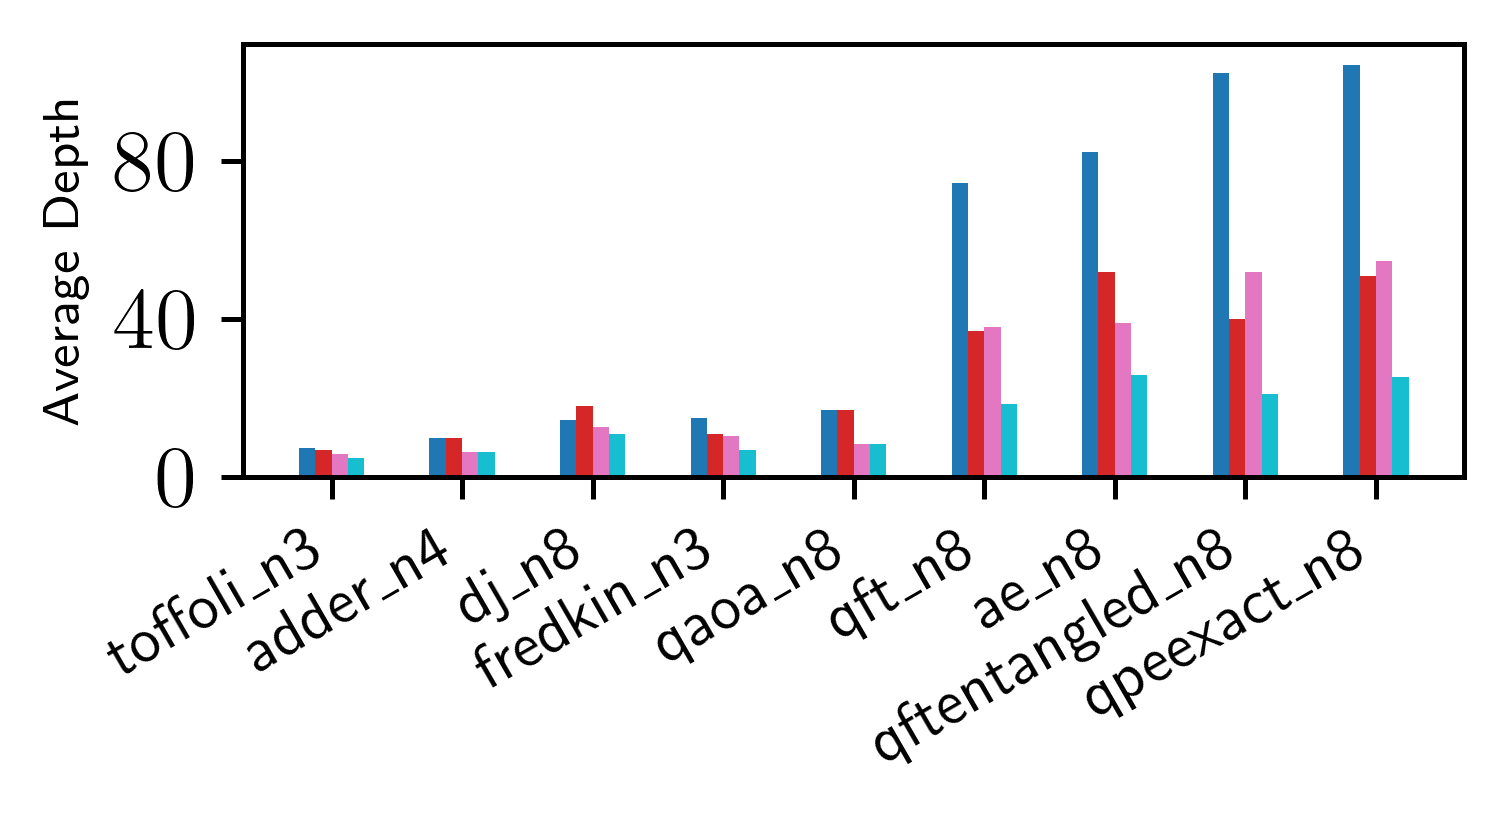

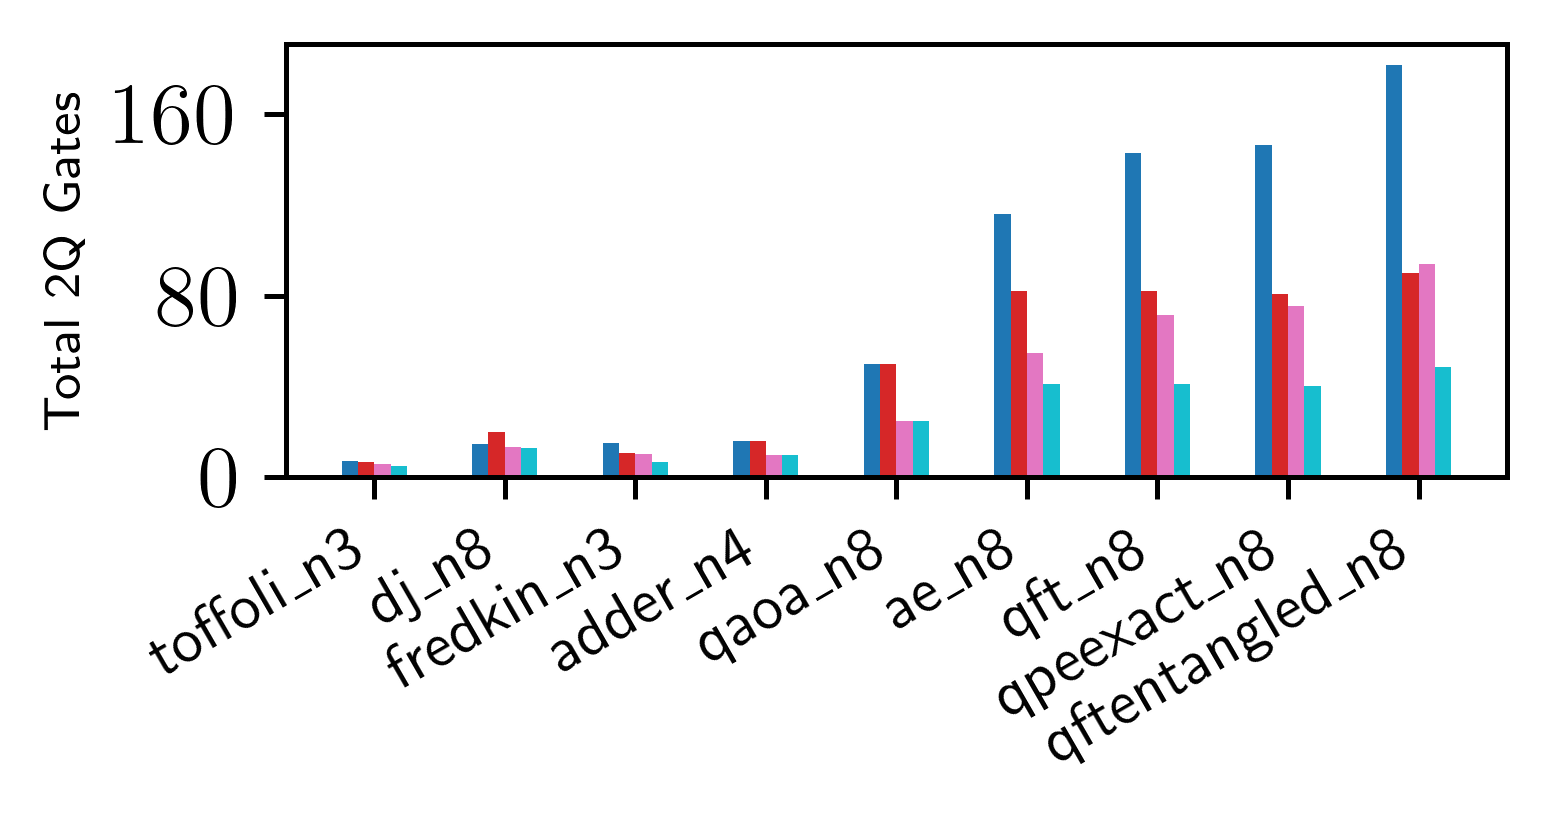

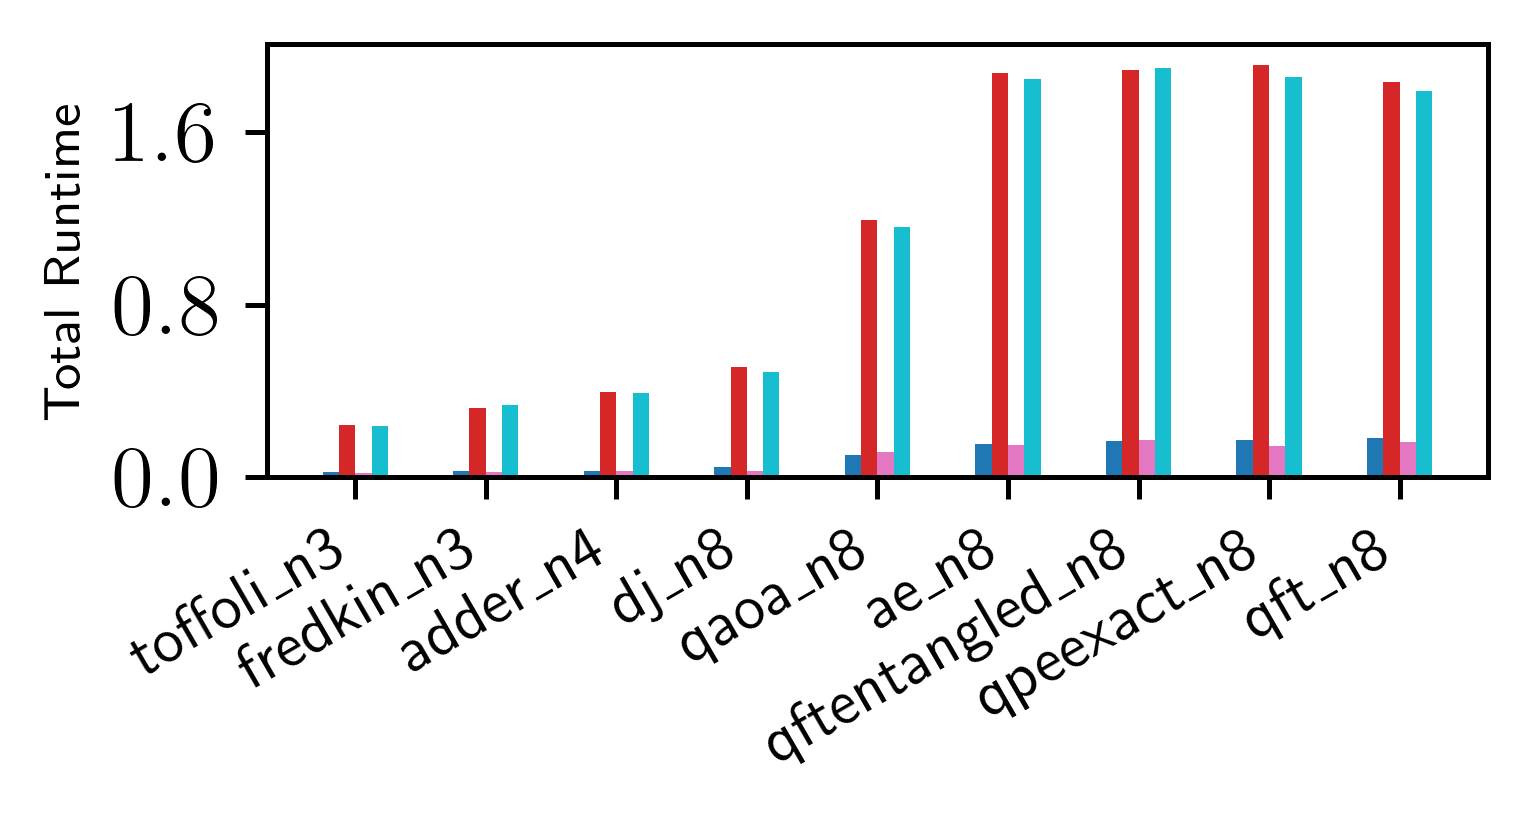

In [8]:
from transpile_benchy.render import plot_benchmark

plot_benchmark(benchmark, save=1, legend_show=0, filename="hex")